# Recurrent Neural Networks

In this lab we will experiment with recurrent neural networks. We will build a text generation model that predicts a word given the previous words, and hence will allow us to generate a sentence. This can easily be extended to generating a sentence description for a given input image. RNNs are a useful type of model for predicting sequences or handling sequences of things as inputs. In this lab we will use again Pytorch's nn library.

We will also be using the COCO dataset which includes images + textual descriptions (captions) + other annotations. We can browse the dataset here: http://cocodataset.org/#home

First, let's import libraries and make sure we have everything properly installed.

In [1]:
!pip install tqdm
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import torch, json, string
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
from nltk.tokenize import word_tokenize

In [3]:
!nvidia-smi

Fri Nov 10 06:35:43 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:0A:00.0     Off |                  N/A |
| 33%   50C    P8    18W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 1. Loading and Preprocessing the Text
Pytorch comes with a Dataset class for the COCO dataset but I will write my own class here. This class does two important things: 

1. Building a __vocabulary__ with the most __frequent words__,
2. Building __utilities__ to convert a __sentence into a list of word ids, and back__. 

We are not going to be using the images for the purposes of the lab but you will use them in the assignment questions.

In [4]:
path = "/data/datasets/mscoco_14/annotations/"

In [5]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm

class CocoCaptions(data.Dataset):
    
    # Load annotations in the initialization of the object.
    def __init__(self, captionsFile, vocabulary = None):
        self.data = json.load(open(captionsFile))
        self.imageIds = self.data['images']
        self.annotations = self.data['annotations']
        
        # Build a vocabulary if not provided.
        if not vocabulary:
            self.build_vocabulary()
        else:
            self.vocabulary = vocabulary
        
        
    # Build a vocabulary using the top 5000 words.
    def build_vocabulary(self, vocabularySize = 5000):
        # Count words, this will take a while.
        word_counter = dict()
        for annotation in tqdm(self.annotations, desc = 'Building vocabulary'):
            words = word_tokenize(annotation['caption'].lower())
            for word in words:
                word_counter[word] = word_counter.get(word, 0) + 1
                
        # Sort the words and find keep only the most frequent words.
        sorted_words = sorted(list(word_counter.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        word2id = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        
        # Add a special characters for START, END sentence, and UNKnown words.
        word2id['[END]'] = 0
        word2id['[START]'] = len(word2id)
        word2id['UNK'] = len(word2id)
        id2word = {index: w for (w, index) in word2id.items()}
        self.vocabulary = {'word2id': word2id, 'id2word': id2word}
    
    # Transform a caption into a list of word ids.
    def caption2ids(self, caption):
        word2id = self.vocabulary['word2id']
        caption_ids = [word2id.get(w, word2id['UNK']) for w in word_tokenize(caption.lower())]
        caption_ids.insert(0, word2id['[START]'])
        caption_ids.append(word2id['[END]'])
        return torch.LongTensor(caption_ids)
    
    # Transform a list of word ids into a caption.
    def ids2caption(self, caption_ids):
        id2word = self.vocabulary['id2word']
        #return string.join([id2word[w] for w in caption_ids], " ")
        return " ".join([id2word[w] for w in caption_ids])
    
    # Return imgId, and a random caption for that image.
    def __getitem__(self, index):
        annotation = self.annotations[index]
        return annotation['image_id'], self.caption2ids(annotation['caption'])
    
    # Return the number of elements of the dataset.
    def __len__(self):
        return len(self.annotations)
    
# Let's test the data class.
trainData = CocoCaptions(path+'captions_train2014.json')
print('Number of training examples: ', len(trainData))

# It would be a mistake to build a vocabulary using the validation set so we reuse.
valData = CocoCaptions(path+'captions_val2014.json', vocabulary = trainData.vocabulary)
print('Number of validation examples: ', len(valData))

# Print a sample from the training data.
imgId, caption = trainData[0]
print('imgId', imgId)
print('caption', caption.tolist())
print('captionString', trainData.ids2caption(caption))

Building vocabulary: 100%|██████████| 414113/414113 [00:39<00:00, 10437.10it/s]


Number of training examples:  414113
Number of validation examples:  202654
imgId 318556
caption [5001, 1, 141, 512, 8, 668, 415, 277, 57, 0]
captionString [START] a very clean and well decorated empty bathroom [END]


## 2. Making a Data Loader that can Handle Sequences.

Handling sequences is special when processing batches of inputs because each sequence can have a different length. This makes batching complicated, and different libraries have different ways of handling this which might be easier or harder to deal with. Here we are padding the sequences to the maximum sequence length in a given batch. Additionally pytorch has nice utility functions that require sorting the sequences in a batch from longest to shortest.

In [6]:
# The batch builder will pack all sequences of different length into a single tensor by 
# padding shorter sequences with a padding token.
def customBatchBuilder(samples):
    imgIds, captionSeqs = zip(*samples)
    
    # Sort sequences based on length.
    seqLengths = [len(seq) for seq in captionSeqs]
    maxSeqLength = max(seqLengths)
    sorted_list = sorted(zip(list(imgIds), captionSeqs, seqLengths), key = lambda x: -x[2])
    imgIds, captionSeqs, seqLengths = zip(*sorted_list)
    
    # Create tensor with padded sequences.
    paddedSeqs = torch.LongTensor(len(imgIds), maxSeqLength)
    paddedSeqs.fill_(0)
    for (i, seq) in enumerate(captionSeqs):
        paddedSeqs[i, :len(seq)] = seq
    return imgIds, paddedSeqs.t(), seqLengths

# Data loaders in pytorch can use a custom batch builder, which we are using here.
trainLoader = data.DataLoader(trainData, batch_size = 128, 
                              shuffle = True, num_workers = 0,
                              collate_fn = customBatchBuilder)
valLoader = data.DataLoader(valData, batch_size = 128, 
                            shuffle = False, num_workers = 0,
                            collate_fn = customBatchBuilder)

# Now let's try using the data loader.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
print('imgIds', imgIds)
print('paddedSequences', paddedSeqs.size())
print('seqLengths', seqLengths)

imgIds (477636, 356344, 382022, 218284, 281351, 206903, 168865, 267201, 481454, 221565, 502485, 120595, 447714, 139675, 198856, 406422, 217276, 564431, 347794, 99636, 85515, 557105, 492297, 446764, 182027, 347884, 39958, 88110, 30321, 436002, 212780, 434539, 515431, 355647, 222371, 292009, 254129, 168294, 554271, 335110, 204052, 154654, 348523, 292358, 575173, 382203, 242712, 262901, 540814, 272790, 521999, 442687, 42297, 221245, 52523, 398025, 56261, 480685, 385464, 205525, 505994, 86234, 303610, 424980, 188154, 277026, 510430, 66642, 362475, 197632, 552336, 195472, 200304, 551284, 465740, 521159, 476871, 531171, 47391, 414954, 522146, 383934, 34038, 33303, 253532, 505038, 299380, 517975, 85626, 5701, 78868, 455334, 165854, 207152, 158378, 491490, 233500, 452250, 30838, 321389, 199381, 509927, 13574, 380097, 556746, 5619, 66118, 555915, 170785, 56677, 250048, 15311, 402598, 378778, 446783, 179681, 211927, 138956, 513918, 12059, 534896, 250735, 343225, 283720, 155951, 189171, 203691, 2



## 3. Building our model using a Recurrent Neural Network.
We will build a model that predicts the next word based on the previous word using a recurrent neural network. Additionally we will be using an Embedding layer which will assign a unique vector to each word. The network will be trained with a softmax + negative log likelihood loss. Similar to classification we will be trying to optimize for the correct word at each time-step.

In [7]:
# By now, we should know that pytorch has a functional implementation (as opposed to class version)
# of many common layers, which is especially useful for layers that do not have any parameters.
# e.g. relu, sigmoid, softmax, etc.
import torch.nn.functional as F

class TextGeneratorModel(nn.Module):
    '''
    The model has three layers: 
       1. An Embedding layer that turns a sequence of word ids into 
          a sequence of vectors of fixed size: embeddingSize.
       2. An RNN layer that turns the sequence of embedding vectors into 
          a sequence of hiddenStates.
       3. A classification layer that turns a sequence of hidden states into a 
          sequence of softmax outputs.
    '''
    def __init__(self, vocabularySize):
        super(TextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        # initialHiddenState (num_layers * num_directions, batch, hidden_size)
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        #print(rnnOutput.size())
        flatSeqOutput = rnnOutput.view(-1, 512)
        #print(flatSeqOutput.size())
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
inputs torch.Size([25, 128])
outputs torch.Size([25, 128, 5003])


## 3. Sampling a New Sentence from the Model.

The code below uses the RNN network as an RNN cell where we only pass one single input word, and a hidden state vector. Then we keep passing the previously predicted word, and previously predicted hidden state to predict the next word. Since the given model is not trained, it will just output a random sequence of words for now. Ideally, the trained model should also learn when to [END] a sentence.

In [8]:
def sample_sentence(model, use_cuda = False):
    counter = 0
    limit = 200
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    if use_cuda: previousHiddenState = previousHiddenState.cuda()

    while True:
        # Predict the next word based on the previous hidden state and previous word.
        inputWord = torch.autograd.Variable(previousWord)
        if use_cuda: inputWord = inputWord.cuda()
        predictions, hiddenState = model(inputWord, previousHiddenState)
        nextWordId = np.random.multinomial(1, F.softmax(predictions.squeeze()).data.cpu().numpy(), 1).argmax()
        words.append(trainData.vocabulary['id2word'][nextWordId])
        
        # DEBUG
#         print(nextWordId)
#         print(type(nextWordId))
#         print(type(int(nextWordId)))
        # DEBUG - end
        
        # Setup the inputs for the next round.
        nextWordId = int(nextWordId) # wants int not int64
        previousWord.fill_(nextWordId) # -------- <
        previousHiddenState = hiddenState

        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    #return string.join(words, " ")
    return " ".join(words)

print(sample_sentence(model, use_cuda = False))

[START] the korean bento waves rope lazy swimmers pickle longboard pours courts organized ready without action best otherwise begin chinese volleyball pear toilets rig dunkin glass toaster separated biscuit difficult teen autumn kiss off bring helmets pass handlebars pitching skylight napkins helmets hazy dining toilette share customer guards bust area awning backed globe stained locations racing skate streaming towering mount way wilted caption businesses meats wireless coming viewer propellers gift doubledecker jumbo ultimate mp3 skating stopping flamingos nature blades charger monument eight observing decorations : fallen power vending octopus gun pulls shelter strapped athlete bricked camera cherries thru guns league nice aged conversing baseman program aged streaming tusk camp reads competing trying photographing plugged viewer number bone idle uses brunette dress motes grassland kids palm judge goes caps barely household worn majestic if oven while lap tourist york tossed exercis

## 3. Training the Model

Now that data is pre-processed, we can try training the model. An important part is to define our target labels or ground-truth labels. In this text generation model, we want to predict the next word based on the previous word. So we need to provide as the target a shifted version of the input sequence. The code below looks a lot like the code used for training previous models with only small modifications.

In [9]:
# import tqdm as tqdmx
#from tqdm import tqdm_notebook as tqdm
# tqdmx.tqdm.get_lock().locks = []

def train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    return

Now to the actual training call, notice how unlike previous experiments we are using here <b>RMSprop</b> which is a different type of optimizer that is often preferred for recurrent neural networks, although others such as SGD, and ADAM will also work. Additionally we are using <b>nn.NLLLoss</b> for the loss function, which is equivalent to the nn.CrossEntropyLoss function used before. The only difference is that nn.CrossEntropyLoss does the log_softmax operation for us, however in our implementation, we already applied log_softmax to the outputs of the model.

In [10]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Train the previously defined model.
train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

In [11]:
print(sample_sentence(model, use_cuda = False))

[START] the smothered outfits fight dusty lizard coaster paddling help brush females vessel tower older news maintained upon treat fashion dugout hay skier bite eaten angles maybe broadway staring pickup runway smile booth wrapping roaming rider putting below streamers sandwhich brand stem chained employee racket hoop sinks reads womans texting mopeds cliffs walking steel races cabin tv reception purchase square washed cheesy livestock burners kites herds curvy workers cuddles diving hamburger sanctuary chute basic liquid page burners religious mitt dated boulders indoor garnish mirrors maneuver narrow granite hospital panoramic cucumber symbol shaped virgin pickup pictured leap mushroom sticking spotted i now in there finger once motel sticky victorian muffins deliver giraffe onto rest force connected ears growing protect projection point paper policemen catchers seafood collie beauty settings sky countryside caption dragging weather sports hump fair nibbling extended cute forrest sin

## Lab Questions (10pts)
<span><b>1.</b></span> (2pts) What is the number of parameters of the TextGeneratorModel? 

In [12]:
# Show how did you come up with that number here.

Our model has <b>4,484,207</b> parameters.

Our model has 3 components to it: (1) embedder; (2) RNN; and (3) classifier.

In [13]:
model

TextGeneratorModel (
  (embedder): Embedding(5003, 300)
  (rnn): RNN(300, 512)
  (classifier): Linear (512 -> 5003)
)

The breakdown of parameters in our model is as follows. 
1. Our embedder has a weight matrix. 
2. Our RNN has two weight matrices -- Whx and a square Whh -- and corresponding bias vectors for both matrices. 
3. Our linear classifier has a weight matrix and a bias vector.

In [14]:
# Embedder
print("Embedder parameters:")
Wemb = model.embedder.weight.size()
print(Wemb)

# RNN
print("\nRNN parameters:")
Whx = model.rnn.weight_ih_l0.size()
print(Whx)
Whh = model.rnn.weight_hh_l0.size()
print(Whh)
B1 = model.rnn.bias_ih_l0.size()
print(B1)
B2 = model.rnn.bias_hh_l0.size()
print(B2)

# Linear classifier
print("\nLinear classifier parameters:")
Wx = model.classifier.weight.size()
print(Wx)
Bx = model.classifier.bias.size()
print(Bx)

print("")
print("-"*30)
print("Total parameters:",
      (Wemb[0]*Wemb[1]) + 
      (Whx[0]*Whx[1]) + (Whh[0]*Whh[1]) + B1[0] + B2[0] + 
      (Wx[0]*Wx[1]) + Bx[0]
     )
print("-"*30)

Embedder parameters:
torch.Size([5003, 300])

RNN parameters:
torch.Size([512, 300])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512])

Linear classifier parameters:
torch.Size([5003, 512])
torch.Size([5003])

------------------------------
Total parameters: 4484207
------------------------------


<span><b>2.</b></span> (4pts) Provide an implementation for the function train_rnn_model from section 3, this will be similar to the train_model function used in the previous lab. Then train the model and report a few sentences generated by your model. Use the following figure as reference to make sure you are using the right inputs and targets to train the model. The loss function between predictions and targets should be __nn.CrossEntropyLoss()__, so you might need to collapse the batch and sequence-length dimensions before passing them to the loss function.

<img src="rnn.png" width="80%"> 

In [28]:
# implement train_rnn_model and then train the model using this function.

import tqdm as tqdmx
from tqdm import tqdm as tqdm
tqdmx.tqdm.get_lock().locks = []

def train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True):

    training_accuracy_values = []
    validation_accuracy_values = []
    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = model.cuda()
        criterion = criterion.cuda()
        
    for epoch in range(0, n_epochs):
        
        #print("Epoch:",epoch)
        
        correct = 0.0
        cu_loss = 0.0
        counter = 0
        
        h0 = Variable(torch.Tensor(1, 128, 512).zero_())
        if use_gpu: h0 = h0.cuda()
        
        j = 0
        
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()
        
        for (i, (img_ids, sequence_batch, sequences_len)) in enumerate(t):
        #for (img_ids, sequence_batch, sequences_len) in trainLoader:
            
            j += 1

            sequence_batch = Variable(sequence_batch)

            if use_gpu:
                sequence_batch = sequence_batch.cuda()

            # Expected hidden size (1, 33, 512), got (1, 128, 512)
            if sequence_batch.size()[1] != 128:
                #print(i) # 3235
                #print(sequence_batch.size()) # torch.Size([18, 33]), [29, 33]
                j -= 1
                pass
            
            else:
                # nn.RNN(300, 512, batch_first = False)
                # False: (batch, seq_len, feature)
                inputs = sequence_batch[:-1,:] # remove last word
                labels = sequence_batch[1:,:]  # remove first word (i.e., ['START'])
                
                outputs, hn = network(inputs, h0) # ([seq-dim: varies, batch-dim: 128], [1,128,512])

                flat_outputs = outputs.view(-1,outputs.size()[2]) # size: 3072x5003
                flat_labels = labels.view(-1)

                loss = criterion(flat_outputs, flat_labels)
                #loss_list.append(loss.data[0])
                
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step()
                
                # logging information.
                cu_loss += loss.data[0]
                #max_scores, max_labels = outputs.data.max(1)
                #correct += (max_labels == labels.data).sum()
                counter += inputs.size(0)
                #t.set_postfix(loss = cu_loss / (1 + j), accuracy = 100 * correct / counter)
        
        # Log batch statistics
        #accuracy = 100 * correct / counter
        #training_accuracy_values.append(accuracy)
        training_loss_values.append(cu_loss / (1 + j))
        
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        correct = 0.0
        cu_loss = 0.0
        counter = 0
        j = 0
        network.eval()  # This is important to call before evaluating!
        
        h0 = Variable(torch.Tensor(1, 128, 512).zero_())
        if use_gpu: h0 = h0.cuda()
            
        #for (img_ids, sequence_batch, sequences_len) in valLoader:
        for (i, (img_ids, sequence_batch, sequences_len)) in enumerate(t):
            
            j += 1

            sequence_batch = Variable(sequence_batch)

            if use_gpu:
                sequence_batch = sequence_batch.cuda()

            # Expected hidden size (1, 33, 512), got (1, 128, 512)
            if sequence_batch.size()[1] != 128:
                #print(i) # 3235
                #print(sequence_batch.size()) # torch.Size([18, 33]), [29, 33]
                j -= 1
                pass
            
            else:
                # nn.RNN(300, 512, batch_first = False)
                # False: (batch, seq_len, feature)
                inputs = sequence_batch[:-1,:] # remove last word
                labels = sequence_batch[1:,:]  # remove first word (i.e., ['START'])
                
                outputs, hn = network(inputs, h0) # ([seq-dim: varies, batch-dim: 128], [1,128,512])

                flat_outputs = outputs.view(-1,outputs.size()[2]) # size: 3072x5003
                flat_labels = labels.view(-1)

                loss = criterion(flat_outputs, flat_labels)

                # logging information.
                cu_loss += loss.data[0]
                #max_scores, max_labels = outputs.data.max(1)
                #correct += (max_labels == labels.data).sum()
                counter += inputs.size(0)
                #t.set_postfix(loss = cu_loss / (1 + j), accuracy = 100 * correct / counter)

        validation_loss_values.append(cu_loss / (1 + j))
        
    return training_loss_values, validation_loss_values

In [16]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0005)

# Train the previously defined model.
# output_test, hn_test = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)
training_loss, validation_loss = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 20, use_gpu = True)

Validation epoch 19: 100%|██████████| 1584/1584 [00:29<00:00, 54.47it/s]


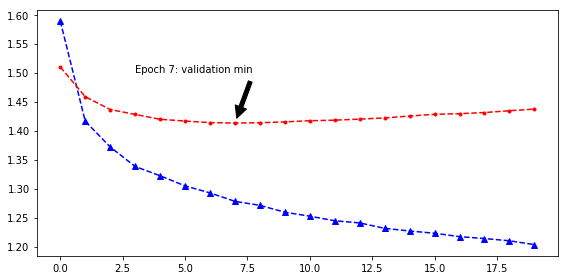

In [37]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(8, 4))

val_min = np.min(validation_loss)
val_min_epoch = validation_loss.index(val_min)
label = 'Epoch ' + str(val_min_epoch) + ': validation min'

plt.plot(training_loss,'b^--')
plt.plot(validation_loss, 'r.--')
plt.annotate(label, xy=(val_min_epoch, val_min), xytext=(3, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            )
plt.tight_layout()

In [39]:
# Show here a couple of sentences sampled from your model.
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))

[START] the airplane is pulled . [END]
[START] the hangar . [END]
[START] the cage converted for dessert as if UNK . '' [END]
[START] the ocean has mountains near the lake . [END]
[START] the dashboard of water that is wind UNK in a field where men . [END]


The above training topped out at 7 epochs, where it thereafter began to over train. The sentences generated are okay, but let's see if we can do better when we reduce the epoch count. Let's also try the Adam optimizer.

In [29]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
#optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0005)

# Train the previously defined model.
# output_test, hn_test = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)
training_loss, validation_loss = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 7, use_gpu = True)

Validation epoch 6: 100%|██████████| 1584/1584 [00:28<00:00, 55.36it/s]


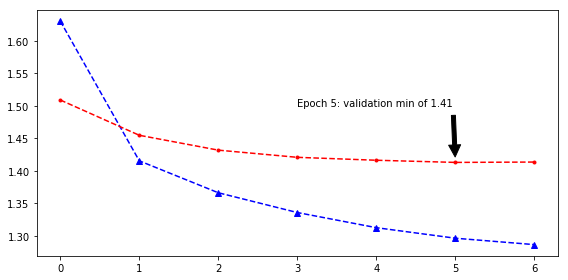

In [30]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(8, 4))

val_min = np.min(validation_loss)
val_min_epoch = validation_loss.index(val_min)
label = 'Epoch ' + str(val_min_epoch) + ': validation min of ' + str(round(val_min, 2))

plt.plot(training_loss,'b^--')
plt.plot(validation_loss, 'r.--')
plt.annotate(label, xy=(val_min_epoch, val_min), xytext=(3, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            )
plt.tight_layout()

In [37]:
# Show here a couple of sentences sampled from your model.
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))
print(sample_sentence(model, use_cuda = True))

[START] the man 's chicken and barbecue sandwich is served on it . [END]
[START] the train track slowly just not lifting blurry smoke . [END]
[START] the winter team observing themselves flying their kites . [END]
[START] the boy blows out the tongue is playing with a red post with bright green and an old clock . [END]
[START] the tip turned rainbow fairly catching waves in UNK [END]


The sentences are perhaps a bit better. At least we're not over-training quite as much now. I won't train this any more, but it could certainly be improved.

<span><b>3. </b></span> (4pts) Create an ImageCaptioningModel class here that predicts a sentence given an input image. This should be an implementation of the model in this paper https://arxiv.org/pdf/1411.4555.pdf (See figure 3 in the paper). This model is very similar to the one implemented in this lab except that the first RNN cell gets the output of a CNN as its input. I'm also illustrating it below using a figure similar to the one in the previous question. For the CNN use Resnet-18. Note: You do not need to train this model, only define it. Feel free to start from the code for the TextGeneratorModel. <img src="im2text.png" width="80%">

In [ ]:
resnet = models.resnet18(pretrained = True)

In [ ]:
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

resnet.eval()
image = Image.open('socrates.jpg').convert('RGB')
inputVar =  Variable(preprocessFn(image).unsqueeze(0))
predictions = resnet(inputVar)

probs, indices = (-F.softmax(predictions)).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

plt.title('\n'.join(preds))
plt.imshow(image);

In [ ]:
class ImageCaptioningModel():
    return
    # using the last hidden layer as an input to the RNNdecoder that generates sentences 

In [ ]:
import torch.nn.functional as F

class TextGeneratorModel(nn.Module):
    '''
    The model has three layers: 
       1. An Embedding layer that turns a sequence of word ids into 
          a sequence of vectors of fixed size: embeddingSize.
       2. An RNN layer that turns the sequence of embedding vectors into 
          a sequence of hiddenStates.
       3. A classification layer that turns a sequence of hidden states into a 
          sequence of softmax outputs.
    '''
    def __init__(self, vocabularySize):
        super(TextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        
        #first RNN cell gets the output of a CNN as its input
        self.embedder = nn.Embedding(vocabularySize, 300)
        
        
        
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        # initialHiddenState (num_layers * num_directions, batch, hidden_size)
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        #print(rnnOutput.size())
        flatSeqOutput = rnnOutput.view(-1, 512)
        #print(flatSeqOutput.size())
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

In [ ]:
# Extract feature vector from final layer of CNN
imageFeatureVector = predictions = resnet(inputVar) # may need to cut off some layers
imageEmbeddingVectors = self.imageEmbedder(imageFeatureVector) # image embedder needs to force it to 300

# Concatenate imageEmbeddingVectors on top of embeddingVectors
captionEmbedding = torch.cat((imageEmbeddingVectors, embeddingVectors))
rnnOutput, finalHiddenState = self.rnn(captionEmbedding, initialHiddenState)


#^----------------------------------^-------------------------------^-------------------------------^
# The above goes into the model definition, and you need to update the train to reference
# the actual images.

# Business as usual?
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Train the previously defined model.
# output_test, hn_test = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True)
training_loss, validation_loss = train_rnn_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 7, use_gpu = True)

### Optional Questions (8pts)

<span><b>1. </b></span> (1pts) What is the number of parameters of the ImageCaptioningModel from Q3?

In [ ]:
# Show how did you come up with that number here.

In the referenced paper, "Show and Tell: A Neural Image Caption Generator", the authors use a pre-trained CNN as an image encodered. I'm going to assume that by "parameters" we're talking specifically about parameters that are learned during the training process of image captioning model. This means that we won't include "hyper-parameters" and we won't count any parameters from the CNN layers, since it is already pre-trained and we are not adjusting any layer weights. That said, we are embedding the output of the CNN into a reduced dimensional space, and this image-embedding layer does have weights associated with it (and we're not including any bias terms). Thus, the total number of parameters in the image captioning model is the total number of parameters from the text generator model, plus the number of parameters from the image embedding layer.

In [ ]:
'''Insert math on image embedding layer!'''

<span><b>2. </b></span> (3pts) Modify the TextGeneratorModel to use an LSTM instead, and retrain the model. Report results using this model.

In [38]:
import torch.nn.functional as F

class LSTMTextGeneratorModel(nn.Module):
    '''
    The model has three layers: 
       1. An Embedding layer that turns a sequence of word ids into 
          a sequence of vectors of fixed size: embeddingSize.
       2. An LSTM layer that turns the sequence of embedding vectors into 
          a sequence of hiddenStates.
       3. A classification layer that turns a sequence of hidden states into a 
          sequence of softmax outputs.
    '''
    def __init__(self, vocabularySize):
        super(LSTMTextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        #self.rnn = nn.RNN(300, 512, batch_first = False)
        self.lstm = nn.LSTM(300,512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState, initialCellState):

        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        # Pass the sequence of word embeddings to the RNN.
        # initialHiddenState (num_layers * num_directions, batch, hidden_size)
        #rnnOutput, finalHiddenState = self.lstm(embeddingVectors, initialHiddenState)
        #embeddingVectors = torch.cat(embeddingVectors).view(1,len(embeddingVectors), -1)
        #print(embeddingVectors.size())

        rnnOutput, finalHiddenState = self.lstm(embeddingVectors,(initialHiddenState, initialCellState))

        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        #print(rnnOutput.size())
        flatSeqOutput = rnnOutput.view(-1, 512)
        #print(flatSeqOutput.size())
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState
        

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = LSTMTextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))

initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
initialCellState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialHiddenState, initialCellState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
inputs torch.Size([29, 128])
outputs torch.Size([29, 128, 5003])


In [39]:
def sample_sentence(model, use_cuda = False):
    counter = 0
    limit = 200
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    previousCellState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    if use_cuda: 
        previousHiddenState = previousHiddenState.cuda()
        previousCellState = previousCellState.cuda()
        model = model.cuda()

    while True:
        # Predict the next word based on the previous hidden state and previous word.
        inputWord = torch.autograd.Variable(previousWord)
        if use_cuda: 
            inputWord = inputWord.cuda()
        predictions, hiddenState = model(inputWord, previousHiddenState,previousCellState)

        nextWordId = np.random.multinomial(1, F.softmax(predictions.squeeze()).data.cpu().numpy(), 1).argmax()
        words.append(trainData.vocabulary['id2word'][nextWordId])
        
        
        # Setup the inputs for the next round.
        nextWordId = int(nextWordId) # wants int not int64
        previousWord.fill_(nextWordId) # -------- <
        # The hiddenState being returned is a tuple
        previousHiddenState = hiddenState[0]
        previousCellState = hiddenState[1]

        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    #return string.join(words, " ")
    return " ".join(words)

print(sample_sentence(model, use_cuda = True))

[START] the layered duffle take headphones steps six sigh opposing seven region plenty under exercise type dunkin travel toward rider today person teapot hello propeller heavy words colored signals fired ready bucket styles bored vent shoulder tv shops frizbee wrestling glass selection claim all peaks chases shelter smiling curiously portrait signage cereal best take farmers featured meatballs drops aged the electronics sided aprons greenery medical fresh register sails right batch men am rolling attraction bushes holiday electronics fixture vendors rotten both somewhere cords utility straw burners even sauce track walkway red wheel rounded knit automatic barriers museum wares gulls burners dressed hello attempts parts potty hides amenities waving waist prominent letting lie attempting vintage buliding eyeglasses day garnish looks wall hitter washroom snowboarder vans gadgets caught gift tongs print scoop sparse handicapped reach doll outhouse hat master pudding buns crafting clip tram

In [40]:
# implement train_lstm_model and then train the model using this function.

import tqdm as tqdmx
from tqdm import tqdm as tqdm
tqdmx.tqdm.get_lock().locks = []

def train_lstm_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True):

    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = model.cuda()
        criterion = criterion.cuda()
        
    for epoch in range(0, n_epochs):
        
        #print("Epoch:",epoch)
        
        correct = 0.0
        cu_loss = 0.0
        counter = 0
        
        h0 = Variable(torch.Tensor(1, 128, 512).zero_())
        c0 = Variable(torch.Tensor(1, 128, 512).zero_())
        
        if use_gpu: 
            h0 = h0.cuda()
            c0 = c0.cuda()
        
        j = 0
        
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()
        
        for (i, (img_ids, sequence_batch, sequences_len)) in enumerate(t):
        #for (img_ids, sequence_batch, sequences_len) in trainLoader:
            
            j += 1

            sequence_batch = Variable(sequence_batch)

            if use_gpu:
                sequence_batch = sequence_batch.cuda()

            # Expected hidden size (1, 33, 512), got (1, 128, 512)
            if sequence_batch.size()[1] != 128:
                j -= 1
                pass
            
            else:
                # False: (batch, seq_len, feature)
                inputs = sequence_batch[:-1,:] # remove last word
                labels = sequence_batch[1:,:]  # remove first word (i.e., ['START'])
                
                outputs, hn = network(inputs,h0,c0) # ([seq-dim: varies, batch-dim: 128], [1,128,512])
                    
                flat_outputs = outputs.view(-1,outputs.size()[2]) # size: 3072x5003
                flat_labels = labels.view(-1)

                loss = criterion(flat_outputs, flat_labels)
                
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step()
                
                # logging information.
                cu_loss += loss.data[0]
                counter += inputs.size(0)
        
        # Log batch statistics
        training_loss_values.append(cu_loss / (1 + j))
        
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        correct = 0.0
        cu_loss = 0.0
        counter = 0
        j = 0
        network.eval()  # This is important to call before evaluating!
        
        h0 = Variable(torch.Tensor(1, 128, 512).zero_())
        c0 = Variable(torch.Tensor(1, 128, 512).zero_())
        
        if use_gpu: 
            h0 = h0.cuda()
            c0 = c0.cuda()
            
        #for (img_ids, sequence_batch, sequences_len) in valLoader:
        for (i, (img_ids, sequence_batch, sequences_len)) in enumerate(t):
            
            j += 1

            sequence_batch = Variable(sequence_batch)

            if use_gpu:
                sequence_batch = sequence_batch.cuda()

            # Expected hidden size (1, 33, 512), got (1, 128, 512)
            if sequence_batch.size()[1] != 128:
                j -= 1
                pass
            
            else:
                # nn.RNN(300, 512, batch_first = False)
                # False: (batch, seq_len, feature)
                inputs = sequence_batch[:-1,:] # remove last word
                labels = sequence_batch[1:,:]  # remove first word (i.e., ['START'])
                
                outputs, hn = network(inputs, h0, c0) # ([seq-dim: varies, batch-dim: 128], [1,128,512])

                flat_outputs = outputs.view(-1,outputs.size()[2]) # size: 3072x5003
                flat_labels = labels.view(-1)

                loss = criterion(flat_outputs, flat_labels)

                # logging information.
                cu_loss += loss.data[0]
                counter += inputs.size(0)

        validation_loss_values.append(cu_loss / (1 + j))
        
    return training_loss_values, validation_loss_values

In [41]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = LSTMTextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Train the previously defined model.
training_loss, validation_loss = train_lstm_model(model, criterion, optimizer, trainLoader, valLoader, n_epochs = 7, use_gpu = True)

Validation epoch 6: 100%|██████████| 1584/1584 [00:29<00:00, 53.92it/s]


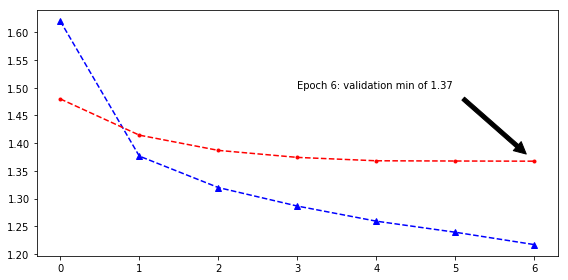

In [42]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(8, 4))

val_min = np.min(validation_loss)
val_min_epoch = validation_loss.index(val_min)
label = 'Epoch ' + str(val_min_epoch) + ': validation min of ' + str(round(val_min,2))

plt.plot(training_loss,'b^--')
plt.plot(validation_loss, 'r.--')
plt.annotate(label, xy=(val_min_epoch, val_min), xytext=(3, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            )
plt.tight_layout()

In [43]:
print(sample_sentence(model, use_cuda = True))
print('\n'+sample_sentence(model, use_cuda = True))
print('\n'+sample_sentence(model, use_cuda = True))
print('\n'+sample_sentence(model, use_cuda = True))

[START] the straw below learn playing disc golf . [END]

[START] the glider alone tail home at home plate . [END]

[START] the basketball stems are given drying on it with a large fork . [END]

[START] the young wine tasting slaw runner . [END]


Let's try training again, but bumping up the number of epochs and using a step decay for the loss function. Hopefully this will improve our results...

In [46]:
# implement train_lstm_model and then train the model using this function.
from torch.optim import lr_scheduler

import tqdm as tqdmx
from tqdm import tqdm as tqdm
tqdmx.tqdm.get_lock().locks = []

def train_lstm_model(model, criterion, optimizer, trainLoader, valLoader, scheduler, n_epochs = 10, use_gpu = True):

    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = model.cuda()
        criterion = criterion.cuda()
        
    for epoch in range(0, n_epochs):
        
        #print("Epoch:",epoch)
        
        correct = 0.0
        cu_loss = 0.0
        counter = 0
        
        h0 = Variable(torch.Tensor(1, 128, 512).zero_())
        c0 = Variable(torch.Tensor(1, 128, 512).zero_())
        
        if use_gpu: 
            h0 = h0.cuda()
            c0 = c0.cuda()
        
        j = 0
        
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()
        
        for (i, (img_ids, sequence_batch, sequences_len)) in enumerate(t):
        #for (img_ids, sequence_batch, sequences_len) in trainLoader:
            
            j += 1

            sequence_batch = Variable(sequence_batch)

            if use_gpu:
                sequence_batch = sequence_batch.cuda()

            # Expected hidden size (1, 33, 512), got (1, 128, 512)
            if sequence_batch.size()[1] != 128:
                j -= 1
                pass
            
            else:
                # False: (batch, seq_len, feature)
                inputs = sequence_batch[:-1,:] # remove last word
                labels = sequence_batch[1:,:]  # remove first word (i.e., ['START'])
                
                outputs, hn = network(inputs,h0,c0) # ([seq-dim: varies, batch-dim: 128], [1,128,512])
                    
                flat_outputs = outputs.view(-1,outputs.size()[2]) # size: 3072x5003
                flat_labels = labels.view(-1)

                loss = criterion(flat_outputs, flat_labels)
                
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step()
                
                # logging information.
                cu_loss += loss.data[0]
                counter += inputs.size(0)
        
        # Log batch statistics
        training_loss_values.append(cu_loss / (1 + j))
        
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        correct = 0.0
        cu_loss = 0.0
        counter = 0
        j = 0
        network.eval()  # This is important to call before evaluating!
        
        h0 = Variable(torch.Tensor(1, 128, 512).zero_())
        c0 = Variable(torch.Tensor(1, 128, 512).zero_())
        
        if use_gpu: 
            h0 = h0.cuda()
            c0 = c0.cuda()
            
        #for (img_ids, sequence_batch, sequences_len) in valLoader:
        for (i, (img_ids, sequence_batch, sequences_len)) in enumerate(t):
            
            j += 1

            sequence_batch = Variable(sequence_batch)

            if use_gpu:
                sequence_batch = sequence_batch.cuda()

            # Expected hidden size (1, 33, 512), got (1, 128, 512)
            if sequence_batch.size()[1] != 128:
                j -= 1
                pass
            
            else:
                # nn.RNN(300, 512, batch_first = False)
                # False: (batch, seq_len, feature)
                inputs = sequence_batch[:-1,:] # remove last word
                labels = sequence_batch[1:,:]  # remove first word (i.e., ['START'])
                
                outputs, hn = network(inputs, h0, c0) # ([seq-dim: varies, batch-dim: 128], [1,128,512])

                flat_outputs = outputs.view(-1,outputs.size()[2]) # size: 3072x5003
                flat_labels = labels.view(-1)

                loss = criterion(flat_outputs, flat_labels)

                # logging information.
                cu_loss += loss.data[0]
                counter += inputs.size(0)

        validation_loss_values.append(cu_loss / (1 + j))
    
        scheduler.step()
        
    return training_loss_values, validation_loss_values

In [47]:
# Changes: start lr at 0.5 and added step LR
vocabularySize = len(trainData.vocabulary['word2id'])
model = LSTMTextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train the previously defined model.
training_loss, validation_loss = train_lstm_model(model, criterion, optimizer, trainLoader, valLoader, lr_scheduler, n_epochs = 90, use_gpu = True)

Validation epoch 56: 100%|██████████| 1584/1584 [00:30<00:00, 52.08it/s]


Validation epoch 89: 100%|██████████| 1584/1584 [00:29<00:00, 54.16it/s]


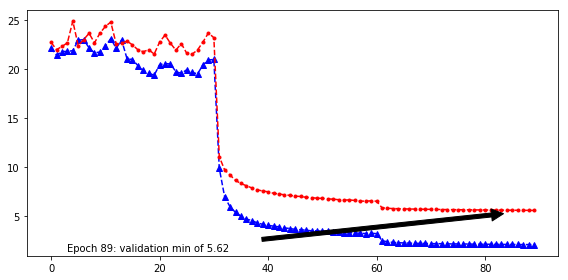

In [48]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(8, 4))

val_min = np.min(validation_loss)
val_min_epoch = validation_loss.index(val_min)
label = 'Epoch ' + str(val_min_epoch) + ': validation min of ' + str(round(val_min,2))

plt.plot(training_loss,'b^--')
plt.plot(validation_loss, 'r.--')
plt.annotate(label, xy=(val_min_epoch, val_min), xytext=(3, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            )
plt.tight_layout()

In [49]:
print(sample_sentence(model, use_cuda = True))
print('\n'+sample_sentence(model, use_cuda = True))
print('\n'+sample_sentence(model, use_cuda = True))
print('\n'+sample_sentence(model, use_cuda = True))

[START] the people are sitting on a man holding a hotdog , and the water and a sink . [END]

[START] the street . [END]

[START] the road . [END]

[START] the door open . [END]


These don't really appear to be any better. Our loss rate is actually higher than our previous attempt, but it confuses me that starting the loss at 0.0005 would start your loss off so much lower than starting with 0.5.

<span><b>3. </b></span> (4pts) In this question, you will have to reconstruct an input image from its activations. I will not provide you with the image, only the activation values obtained for a certain layer. You will have access to the code that was used to compute these activations. You will have to use back-propagation to reconstruct the input image. Show the reconstructed input image and tell us who is in the picture. Note: Look at the content reconstruction from outputs performed in https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html

In [43]:
import torchvision.models as models
model = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:01<00:00, 8959579.63it/s]


In [44]:
import pickle
import torchvision.transforms as transforms
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

def model_F(input, kOutput = 19):
    prev_input = input
    for layer_id in range(0, kOutput + 1):
        current_input = model.features[layer_id](prev_input)
        prev_input = current_input
    return current_input

# Read the incognito image. (Obviously this is not provided in the Lab assignment.)
#image = preprocessFn(Image.open('incognito.jpg').convert('RGB'))
#image = Variable(image.unsqueeze(0))

# Obtain the output of the VGG layer 19.
#model.eval()
#target = Variable(model_F(image).data) # Repack variable.

#print('image.size()', image.size())
#print('layer-19-output.size()', target.size())
#torch.save(target.data, open('layer-19-output.p', 'w'))

'''
('image.size()', torch.Size([1, 3, 224, 224]))
('layer-19-output.size()', torch.Size([1, 512, 28, 28]))
'''

"\n('image.size()', torch.Size([1, 3, 224, 224]))\n('layer-19-output.size()', torch.Size([1, 512, 28, 28]))\n"

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    # convert torch tensor to PIL image and then show image inline.
    img = transforms.ToPILImage()(img[0].cpu() * 0.5 + 0.5) # denormalize tensor before convert
    plt.imshow(img, aspect = None)
    plt.axis('off')
    plt.gcf().set_size_inches(5, 5)
    plt.show()

# target = torch.load(open('layer-19-output.p'))
# print(target.size())
'''torch.Size([1, 512, 28, 28])'''

# Your solution goes here. Show the reconstructed input and tell us who is depicted in the incognito.jpg image.

'torch.Size([1, 512, 28, 28])'

Load the activation values

In [47]:
with open('layer-19-output.p', 'rb') as pickle_file:
    target_activations = torch.load(pickle_file)
    target_activations = Variable(target_activations.cuda())
print(target_activations.size())
print(type(target_activations))

torch.Size([1, 512, 28, 28])
<class 'torch.autograd.variable.Variable'>


"To visualise the image information that is encoded at
different layers of the hierarchy one can perform gradient
descent on a white noise image to find another image that
matches the feature responses of the original image (Fig 1,
content reconstructions)" (p. 3)

In [48]:
vgg_model = models.vgg16(pretrained = True)

In [49]:
# Building our model this way will avoid problems with the computational graph
class VGGnet(nn.Module):
            def __init__(self):
                super(VGGnet, self).__init__()
                self.features = nn.Sequential(
                    # stop at layer 20
                    *list(vgg_model.features.children())[0:20]
                )
            def forward(self, x):
                x = self.features(x)
                return x

vgg_model = VGGnet()

I experimented with this up to 100,000 epochs. I found that the image was pretty clear after 10,000-20,000 epochs. Going higher seems to just bring clarity to edges, which was actually helpful in being able to notice type of glasses she was wearing.

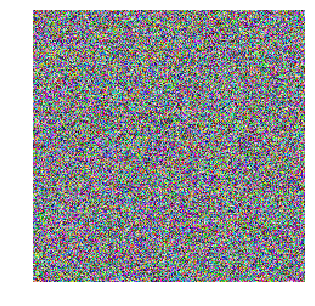

210.4827582836151


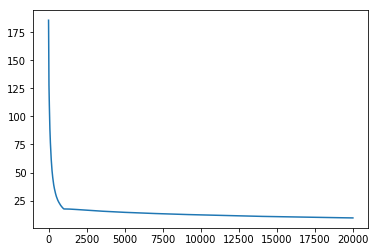

In [50]:
import time

noise_image = np.random.random((256,256,3))
noise_image = Image.fromarray(np.uint8(noise_image * 255)).convert('RGB')
inputVar =  Variable(preprocessFn(noise_image).unsqueeze(0).cuda(), requires_grad=True)

imshow(inputVar.data)

my_model = VGGnet().cuda()
criterion = nn.MSELoss().cuda()

loss_list = []
t0 = time.time()

# Iterate through VGG, updating pixels
for i in range(0,20000):
    
    # Note: After about 10,000 you have a pretty clear pic
    if i <= 20: 
        lr = .1
    elif i <= 1000:
        lr = 0.01
    elif i <= 2000:
        lr = 0.00001

    inputVar.data.clamp_(0, 1)
    output = my_model(inputVar)
    loss = criterion(output, target_activations)
    loss_list.append(loss.data[0])
    loss.backward()

    # Update input
    inputVar.data -= inputVar.grad.data * lr

tn = time.time()
print(tn - t0)

plt.plot(loss_list)

9.530532836914062


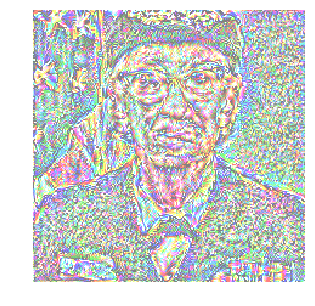

In [51]:
print(loss.data[0])
imshow(inputVar.data)

This is __Grace Hopper__. She was a computer scientist and US Navy Admiral. She invented one of the first compiler related tools.

<img src="grace_hopper.png" width="50%">

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>